# GPcounts applied to bulk RNA-Seq time series data

Nuha BinTayyash, 2020

GPcounts is a Gaussian process regression package for counts data with negative binomial and zero-inflated negative binomial likelihoods as described in the paper "Non-parametric modelling of temporal and spatial counts data from RNA-seq experiments".

This notebook shows how to run GPcounts with a negative binomial likelihood and we compare results with the more standard Gaussian likelihood to find differentially expressed genes using infer trajectory, one sample and two samples cases on the [fission yeast](https://bioconductor.org/packages/release/data/experiment/html/fission.html) gene expression dataset.

In [1]:
import numpy as np
import pandas as pd
import gpflow
from IPython.display import display

In [2]:
import tensorflow as tf 

In [3]:
tf.__version__

'2.7.0'

In [4]:
gpflow.__version__

'2.3.0'

In [5]:
filename = '../data/fission_normalized_counts.csv'
Y = pd.read_csv(filename,index_col=[0])
X = pd.read_csv('../data/fission_col_data.csv',index_col=[0])
X = X[['minute']]

In [6]:
from GPcounts.GPcounts_Module import Fit_GPcounts

Extract time series data for one gene

In [7]:
genes_name = ['SPAC11D3.01c']
gp_counts = Fit_GPcounts(X.iloc[0:18,:],Y.iloc[:,0:18].loc[genes_name]) 

## 1. Using GP regression to learn hyper-parameters and infer trajectories 

In [8]:
likelihood = 'Negative_binomial' # choose the likelihood
results = gp_counts.Infer_trajectory(likelihood)
display(results)

  0%|                                                     | 0/1 [00:00<?, ?it/s]2022-02-01 11:00:22.108166: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-01 11:00:22.161545: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.41s/it]


,Dynamic_model_log_likelihood
SPAC11D3.01c,-119.660177


### Save GPflow models

By default, GPcounts create GPcounts_models folder to save GPflow models as checkpoints using tf.train.Checkpoint throughout the training procedure. The package saves single GPflow model, per each GP fit for each single gene and for each likelihood.

To change the default folder name, use gp_counts object to set Folder name parameter.

In [9]:
gp_counts.folder_name = 'test_folder/'
likelihood = 'Negative_binomial' # choose the likelihood
results = gp_counts.Infer_trajectory(likelihood)
display(results)

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


,Dynamic_model_log_likelihood
SPAC11D3.01c,-119.660177


###  Print GP hyper-parameters

To print GP hyper-parameters, use GPcounts object to call load_predic_models() method that loads GPflow models for list of genes and make prediction with the selected likelihood. Predict argument is true by default, to load models only set predict to False.  

\** Note that gp_counts object is shared between different tests and likelihoods so you have to specify the test and likelihood you want to load its results.

In [10]:
genes_name = results.index.values # list of ganes name 
test_name = 'Infer_trajectory' # name of the test
params = gp_counts.load_predict_models(genes_name,test_name,likelihood)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


###### load_predict_models() method returns params and params is a dictionary of three items

I. params['models'][0] is list of GPflow models of the first gene <br />

In [11]:
gpflow.utilities.print_summary(params['models'][0], fmt='notebook')

name,class,transform,prior,trainable,shape,dtype,value
list[0].kernel.variance,Parameter,Softplus,,True,(),float64,19.19422219988361
list[0].kernel.lengthscales,Parameter,Softplus,,True,(),float64,190.2887983800859
list[0].likelihood.alpha,Parameter,Softplus,,True,(),float64,0.18464379353354757
list[0].q_mu,Parameter,Identity,,True,"(18, 1)",float64,[[1.09638800e+00...
list[0].q_sqrt,Parameter,FillTriangular,,True,"(1, 18, 18)",float64,"[[[4.42862653e-02, 0.00000000e+00, 0.00000000e+00..."


II. params['means'][0] is list of means predicted using GPflow models <br />

III. params['vars'][0] is list of variances/percentiles predicted using GPflow models <br />

### Plot GP posterior predictive distribution 

To plot the fit of GP model on genes use plot function from helper.py file. In plot function we plot the GP posterior predictive distribution for each model and show $\pm1$ standard deviation in dark shade and $\pm2$ standard deviation in light shade for Gaussian likelihood and its equivalent percentiles for non-Gaussian likelihoods.

SPAC11D3.01c


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,19.19422219988361
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,190.2887983800859
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.18464379353354757
VGP.q_mu,Parameter,Identity,,True,"(18, 1)",float64,[[1.09638800e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 18, 18)",float64,"[[[4.42862653e-02, 0.00000000e+00, 0.00000000e+00..."


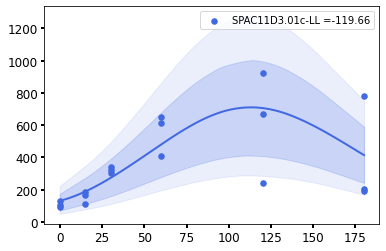

In [12]:
from helper import plot 
plot(params,X.iloc[0:18,:].values,Y.iloc[:,0:18].loc[genes_name],results)

###  Initialize GP hyper-parameters

To replace the initial values for GPflow hyper-parameters, use GPcounts object to call init_hyper_parameters(length_scale,variance,alpha,km) method.

In [13]:
length_scale = 1.
variance = 1.
alpha = 1.
km = 1.
gp_counts.initialize_hyper_parameters(length_scale,variance,alpha,km)

In [14]:
results = gp_counts.Infer_trajectory(likelihood)
display(results)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.65it/s]


,Dynamic_model_log_likelihood
SPAC11D3.01c,-131.809993


To restore the default hyper-parameters initialization for GPcounts call gp_counts.initialize_hyper_parameters() without sending any arguments

In [15]:
gp_counts.initialize_hyper_parameters()

To use GPcounts with Gaussian likelihood assuming log counts transformation $log(y+1)$ change the likelihood parameter

In [16]:
likelihood = 'Gaussian' # change the likelihood to Gaussian will apply log count tramsformation log(y+1) 
results = gp_counts.Infer_trajectory(likelihood)
display(results)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.58it/s]


,Dynamic_model_log_likelihood
SPAC11D3.01c,-18.196204


Load GPflow models for Gaussian likelihood and print hyper-parameters

In [17]:
params = gp_counts.load_predict_models(genes_name,test_name,likelihood)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.25it/s]


In [18]:
gpflow.utilities.print_summary(params['models'][0], fmt='notebook')

name,class,transform,prior,trainable,shape,dtype,value
list[0].kernel.variance,Parameter,Softplus,,True,(),float64,18.2182
list[0].kernel.lengthscales,Parameter,Softplus,,True,(),float64,184.612
list[0].likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.198906


Plot GP fit for Gaussian likelihood

SPAC11D3.01c


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,18.2182
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,184.612
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.198906


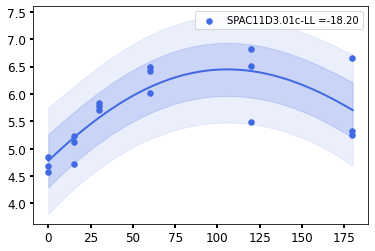

In [19]:
plot(params,X.iloc[0:18,:].values,Y.iloc[:,0:18].loc[genes_name],results)

To use GPcounts with Gaussian likelihood assuming any other transformation (not log count) change the likelihood parameter to Gaussian, set transform parameter to False and pass y transformed to GPcounts

\* Y is transformed using Anscombe transformation.ipynb notebook from [SpatialDE](https://github.com/Teichlab/SpatialDE) package

In [20]:
filename = '../data/Anscombe_transformation_fission_normalized_counts.csv'
Y_transformed = pd.read_csv(filename,index_col=[0]) # Y is transformed using Anscombe transformation
gp_counts = Fit_GPcounts(X.iloc[0:18,:],Y_transformed.iloc[:,0:18].loc[genes_name]) 

In [21]:
likelihood = 'Gaussian'
results = gp_counts.Infer_trajectory(likelihood,transform = False)
display(results)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


,Dynamic_model_log_likelihood
SPAC11D3.01c,49.561726


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.90it/s]

SPAC11D3.01c


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.0608281
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,313.893
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,9.04637e-05


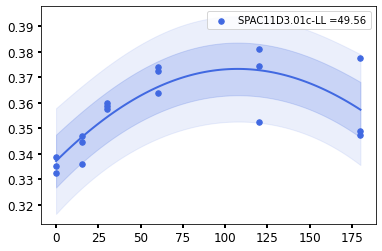

In [22]:
params = gp_counts.load_predict_models(genes_name,test_name,likelihood)
plot(params,X.iloc[0:18,:].values,Y_transformed.iloc[:,0:18].loc[genes_name],results)

## 2. One-sample test

In a one-sample test we compute the log-likelihood ratio (LLR) between a dynamic and constant model

In [23]:
gp_counts = Fit_GPcounts(X.iloc[0:18,:],Y.iloc[:,0:18].loc[genes_name]) 

In [24]:
likelihood = 'Negative_binomial' 
results = gp_counts.One_sample_test(likelihood)
display(results)

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.80s/it]


,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio
SPAC11D3.01c,-119.660177,-125.401876,5.7417


Change test type to one sample test then load GPflow models and plot the GP fit 

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]

SPAC11D3.01c


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,19.19422219988361
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,190.2887983800859
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.18464379353354757
VGP.q_mu,Parameter,Identity,,True,"(18, 1)",float64,[[1.09638800e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 18, 18)",float64,"[[[4.42862653e-02, 0.00000000e+00, 0.00000000e+00..."


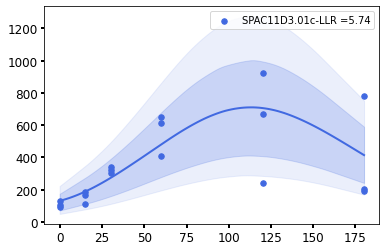

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,32.260803655768996
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.48101989847828486
VGP.q_mu,Parameter,Identity,,True,"(18, 1)",float64,[[1.03654944e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 18, 18)",float64,"[[[-2.87784468e-02, 0.00000000e+00, 0.00000000e+00..."


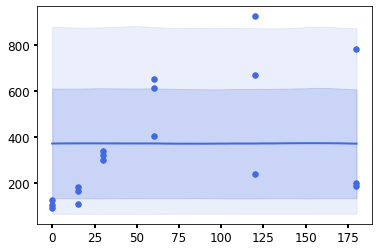

In [25]:
test_name = 'One_sample_test' 
params = gp_counts.load_predict_models(genes_name,test_name,likelihood)
plot(params,X.iloc[0:18,:].values,Y.iloc[:,0:18].loc[genes_name],results)

In [26]:
likelihood = 'Gaussian' 
results = gp_counts.One_sample_test(likelihood)
display(results)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio
SPAC11D3.01c,-18.196204,-23.305036,5.108833


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.97it/s]

SPAC11D3.01c


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,18.2182
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,184.612
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.198906


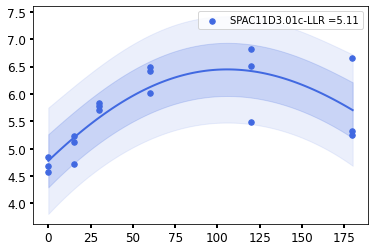

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,31.737
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.529141


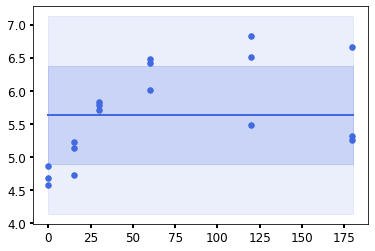

In [27]:
params = gp_counts.load_predict_models(genes_name,test_name,likelihood)
plot(params,X.iloc[0:18,:].values,Y.iloc[:,0:18].loc[genes_name],results)

## 3. Two-sample test

In a two-sample test we test the LLR between a model where the two time-series are replicates (same mean trajectory) and a model where the tractories are different (independent trajectories).

First we create a new GPcounts object to containing time series from two different conditions

In [28]:
gp_counts = Fit_GPcounts(X,Y.loc[genes_name])

Below we carry out a two sample test with a negative binomial likelihood 

The shared-trajectory model has a lower log-likelihood than the sum of the independent model log-likelihood, providing evidence that the trajectories are different. 

In [29]:
likelihood = 'Negative_binomial' 
results = gp_counts.Two_samples_test(likelihood)
display(results)

100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  5.00s/it]


,Shared_log_likelihood,model_1_log_likelihood,model_2_log_likelihood,log_likelihood_ratio
SPAC11D3.01c,-229.368179,-119.660177,-109.485276,0.222727


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.11s/it]

SPAC11D3.01c


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,16.012817764796097
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,201.59658837632117
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.2078973305085352
VGP.q_mu,Parameter,Identity,,True,"(36, 1)",float64,[[1.23324847e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 36, 36)",float64,"[[[3.61383962e-02, 0.00000000e+00, 0.00000000e+00..."


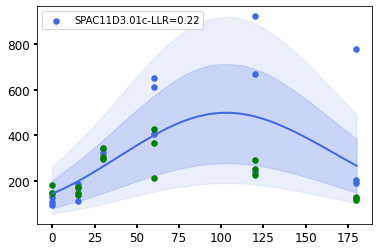

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,19.19422219988361
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,190.2887983800859
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.18464379353354757
VGP.q_mu,Parameter,Identity,,True,"(18, 1)",float64,[[1.09638800e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 18, 18)",float64,"[[[4.42862653e-02, 0.00000000e+00, 0.00000000e+00..."


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,23.68865041378606
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,41.63332046696607
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.02895899970109392
VGP.q_mu,Parameter,Identity,,True,"(18, 1)",float64,[[1.03382056e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 18, 18)",float64,"[[[2.17381523e-02, 0.00000000e+00, 0.00000000e+00..."


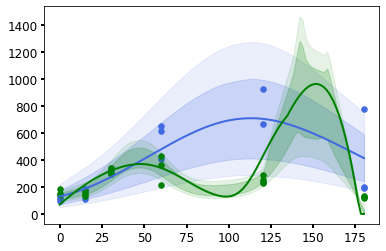

In [30]:
test_name = 'Two_samples_test'
params = gp_counts.load_predict_models(genes_name,test_name,likelihood)
plot(params,X.values,Y.loc[genes_name],results)

### Safe mode option

Set safe_mode to True to check:
1. if the mean of the GP posterior predictive distribution is in the mean of the data.
2. if the log-likelihood ratio LLR < 0 for small lengthscale or if the LLR takes on extreme values that would indicate a very large difference between the time-varying GP and constant model.

In [31]:
gp_counts = Fit_GPcounts(X,Y.loc[genes_name],safe_mode = True)
likelihood = 'Negative_binomial' 
results = gp_counts.Two_samples_test(likelihood)
display(results)

100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.39s/it]


,Shared_log_likelihood,model_1_log_likelihood,model_2_log_likelihood,log_likelihood_ratio
SPAC11D3.01c,-229.368179,-119.660177,-103.858239,5.849764


Now we carry out a two sample test with a Gaussian likelihood - in this case the shared model has a higher log-likelihood than the sum of the independent model log-likelihoods

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.07s/it]

SPAC11D3.01c


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,16.012817764796097
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,201.59658837632117
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.2078973305085352
VGP.q_mu,Parameter,Identity,,True,"(36, 1)",float64,[[1.23324847e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 36, 36)",float64,"[[[3.61383962e-02, 0.00000000e+00, 0.00000000e+00..."


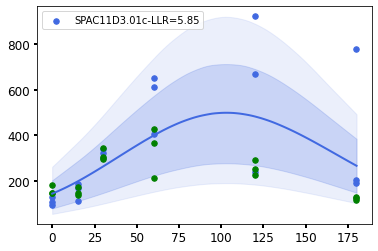

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,19.19422219988361
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,190.2887983800859
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.18464379353354757
VGP.q_mu,Parameter,Identity,,True,"(18, 1)",float64,[[1.09638800e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 18, 18)",float64,"[[[4.42862653e-02, 0.00000000e+00, 0.00000000e+00..."


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,15.800749599709693
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,211.8438481466521
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.04990889798150496
VGP.q_mu,Parameter,Identity,,True,"(18, 1)",float64,[[1.27330781e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 18, 18)",float64,"[[[2.64931477e-02, 0.00000000e+00, 0.00000000e+00..."


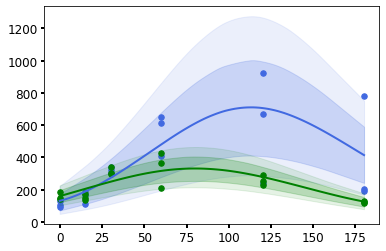

In [32]:
test_name = 'Two_samples_test'
params = gp_counts.load_predict_models(genes_name,test_name,likelihood)
plot(params,X.values,Y.loc[genes_name],results)

In [33]:
likelihood = 'Gaussian' 
results = gp_counts.Two_samples_test(likelihood)
display(results)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


,Shared_log_likelihood,model_1_log_likelihood,model_2_log_likelihood,log_likelihood_ratio
SPAC11D3.01c,-29.525785,-18.196204,-13.585455,-2.255874


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.71it/s]

SPAC11D3.01c


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,15.8659
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,190.845
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.19391


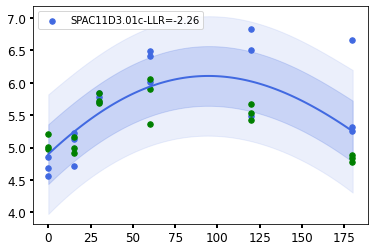

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,18.2182
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,184.612
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.198906


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,22.0624
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,40.2707
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0326889


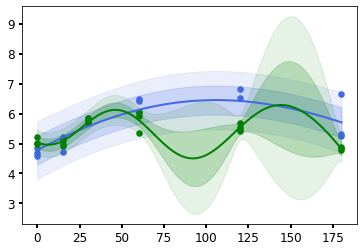

In [34]:
params = gp_counts.load_predict_models(genes_name,test_name,likelihood)
plot(params,X.values,Y.loc[genes_name],results)